In [37]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [38]:
audit_trial_data <- read_csv("https://raw.githubusercontent.com/fulleraltamiranoe/audit_data/main/trial.csv")
audit_risk_data <- read_csv("https://raw.githubusercontent.com/fulleraltamiranoe/audit_data/main/audit_risk.csv")

Parsed with column specification:
cols(
  Sector_score = col_double(),
  LOCATION_ID = col_character(),
  PARA_A = col_double(),
  SCORE_A = col_double(),
  PARA_B = col_double(),
  SCORE_B = col_double(),
  TOTAL = col_double(),
  numbers = col_double(),
  Marks = col_double(),
  Money_Value = col_double(),
  MONEY_Marks = col_double(),
  District = col_double(),
  Loss = col_double(),
  LOSS_SCORE = col_double(),
  History = col_double(),
  History_score = col_double(),
  Score = col_double(),
  Risk = col_double()
)

Warning message:
“Duplicated column names deduplicated: 'Score_B' => 'Score_B_1' [11]”
Parsed with column specification:
cols(
  .default = col_double(),
  LOCATION_ID = col_character()
)

See spec(...) for full column specifications.



In [10]:
audit_trial_data
audit_risk_data

Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,6,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,6,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,14,0.24,2,0.04,2,0.28,5,2,0.00,2,2,0,2,0,2,2,0
55.57,18,0.20,2,0.00,2,0.20,5,2,0.00,2,2,0,2,0,2,2,0
55.57,15,0.00,2,0.00,2,0.00,5,2,0.32,2,2,0,2,0,2,2,0


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,14,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5,⋯,0.4,0,0.2,0,2,1.456,0.4,0.5,0.2912,0
55.57,18,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5,⋯,0.4,0,0.2,0,2,1.440,0.4,0.5,0.2880,0
55.57,15,0.00,0.2,0.000,0.00,0.2,0.000,0.00,5,⋯,0.4,0,0.2,0,2,1.464,0.4,0.5,0.2928,0


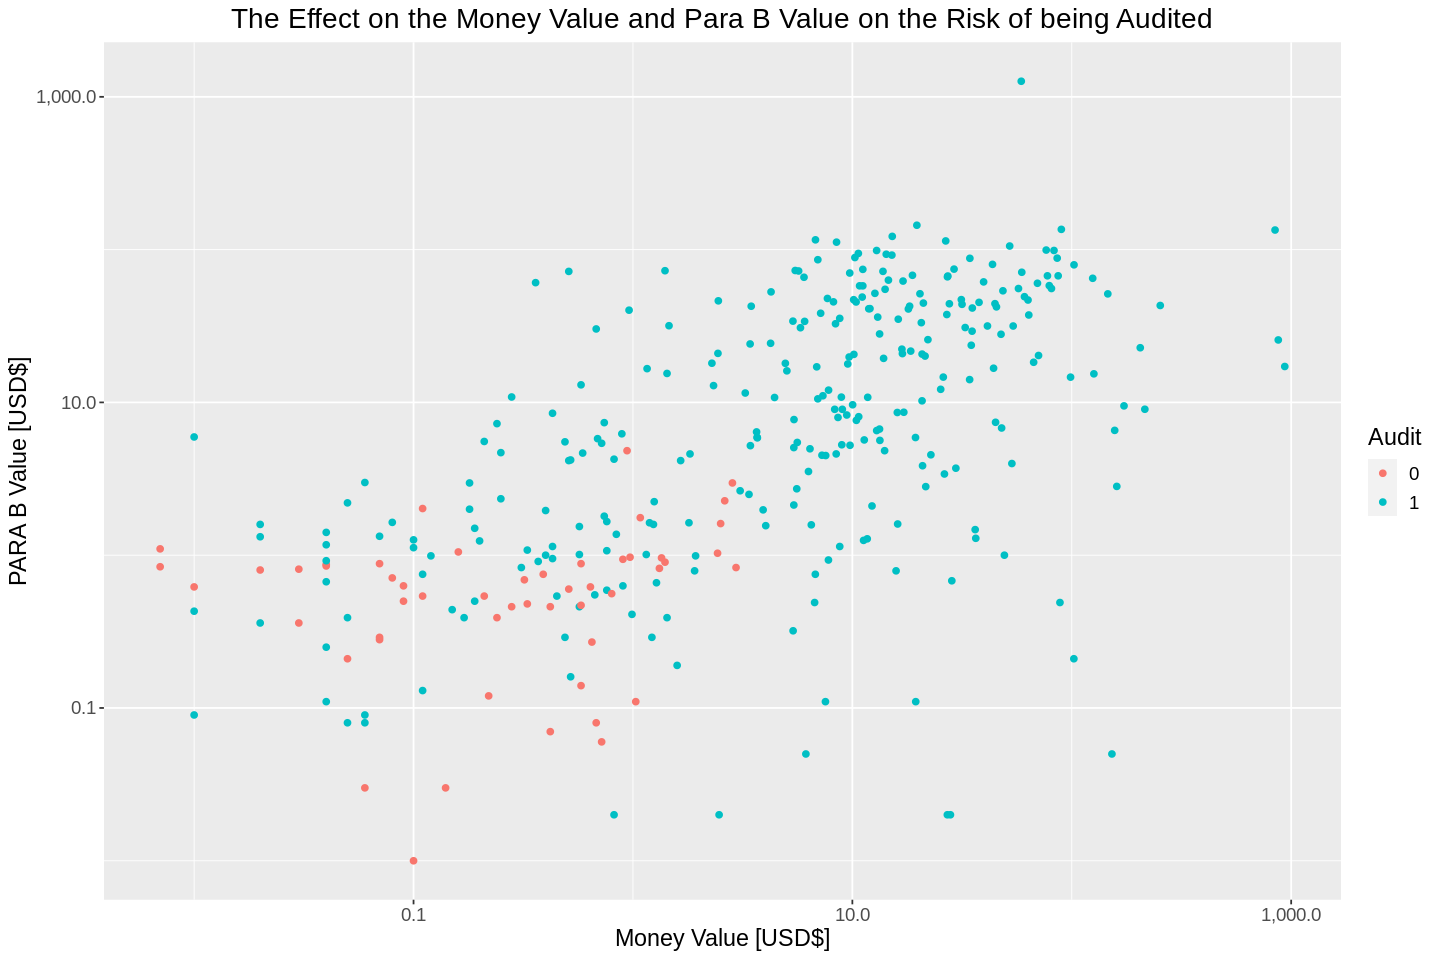

In [48]:
####EDGARS CODE
options(repr.plot.width = 12, repr.plot.height = 8) 
library(scales)
# Treat Risk as a categorical variable.
audit_trial <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk)) %>%
    filter(PARA_B > 0, Money_Value > 0)


# Plot our initial data (we are going to try to predict Risk). Money Value and PARA_B have very
# large and very small values. Hence a log scale might be more appropriate. We'll filter out
# the 0 values in these two since they will not help in our prediction. 

audit_plot <- audit_trial  %>%
    ggplot(aes(x = Money_Value, y = PARA_B, colour = Risk)) +
    geom_point() +
    labs(x = "Money Value [USD$]", y = "PARA B Value [USD$]", colour = "Audit") +
    ggtitle("The Effect on the Money Value and Para B Value on the Risk of being Audited") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) 
audit_plot

#As PARA_B value increases, so does the Money_Value. At that point all companies were audited

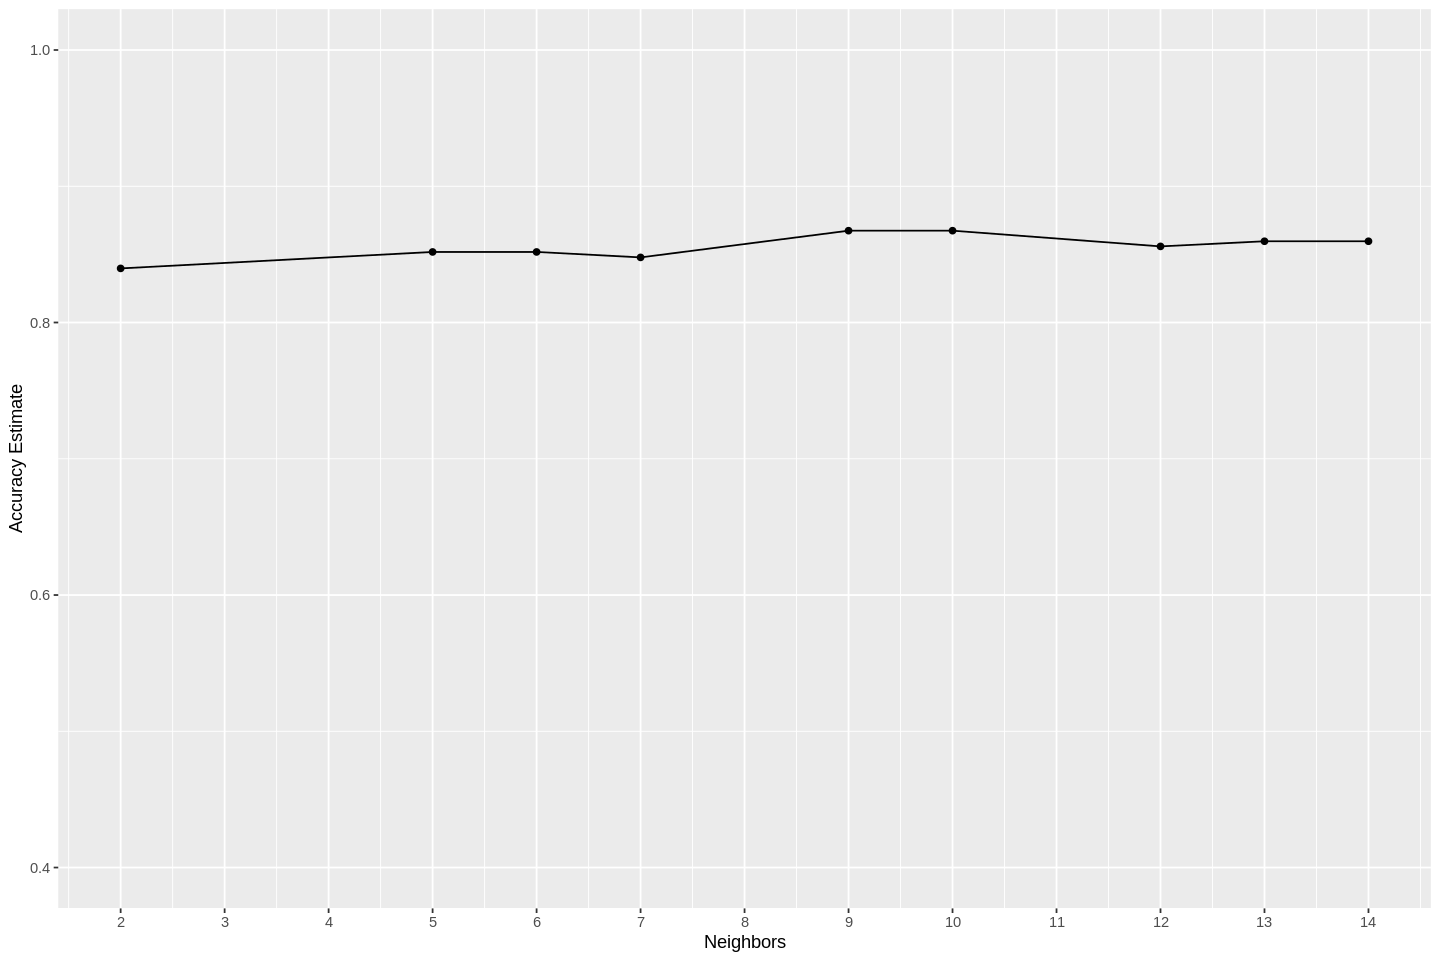

In [49]:
set.seed(1001)

# Splitting data into training and testing sets
audit_split <- initial_split(audit_trial, prop = 3/4, strata = Risk)  
audit_train <- training(audit_split)   
audit_test <- testing(audit_split)

# Training
audit_recipe <- recipe(Risk ~ PARA_B + Money_Value, data = audit_train) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

# tuning, how many K?
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_vfold <- vfold_cv(audit_train, v = 5, strata = Risk)

knn_results <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = 10) %>%
    collect_metrics()

accuracies <- knn_results %>% 
    filter(.metric == 'accuracy')

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [50]:
## K = 9 seems to be the most accurate
audit_knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 9) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_fit <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(audit_knn_spec) %>%
    fit(data = audit_train)

audit_test_predictions <- predict(audit_fit, audit_test) %>%
    bind_cols(audit_test)

predictions_accuracy <- audit_test_predictions %>%
    metrics(truth = Risk, estimate = .pred_class)             

predictions_accuracy

audit_mat <- audit_test_predictions %>% 
    conf_mat(truth = Risk, estimate = .pred_class)   

audit_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8588235
kap,binary,0.4551282


          Truth
Prediction  0  1
         0  7  6
         1  6 66

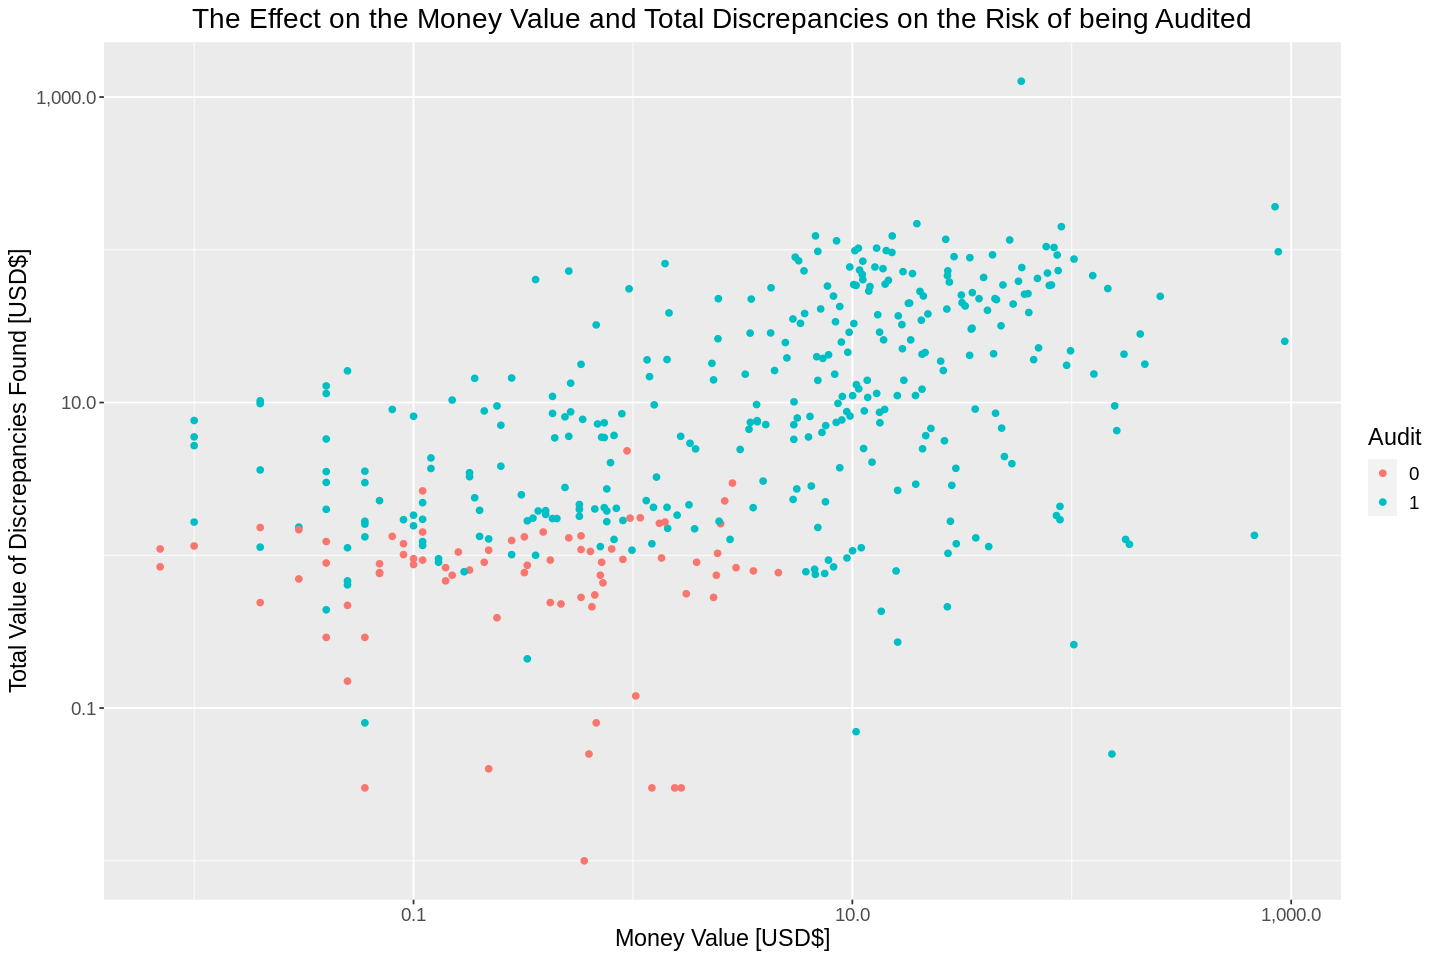

In [51]:
## SECOND APPROACH, I WANNA SEE THE RELATIONSHIP BETWEEN THE ACTUAL MONEY MADE AND LOST (total discrepancies)

####EDGARS CODE
options(repr.plot.width = 12, repr.plot.height = 8) 
library(scales)
# Treat Risk as a categorical variable.
audit_trial2 <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk)) %>%
    filter(TOTAL > 0, Money_Value > 0)

audit_plot_2 <- audit_trial2 %>%
    ggplot(aes(x = Money_Value, y = TOTAL, colour = Risk)) +
    geom_point() +
    labs(x = "Money Value [USD$]", y = "Total Value of Discrepancies Found [USD$]", colour = "Audit") +
    ggtitle("The Effect on the Money Value and Total Discrepancies on the Risk of being Audited") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) 
audit_plot_2

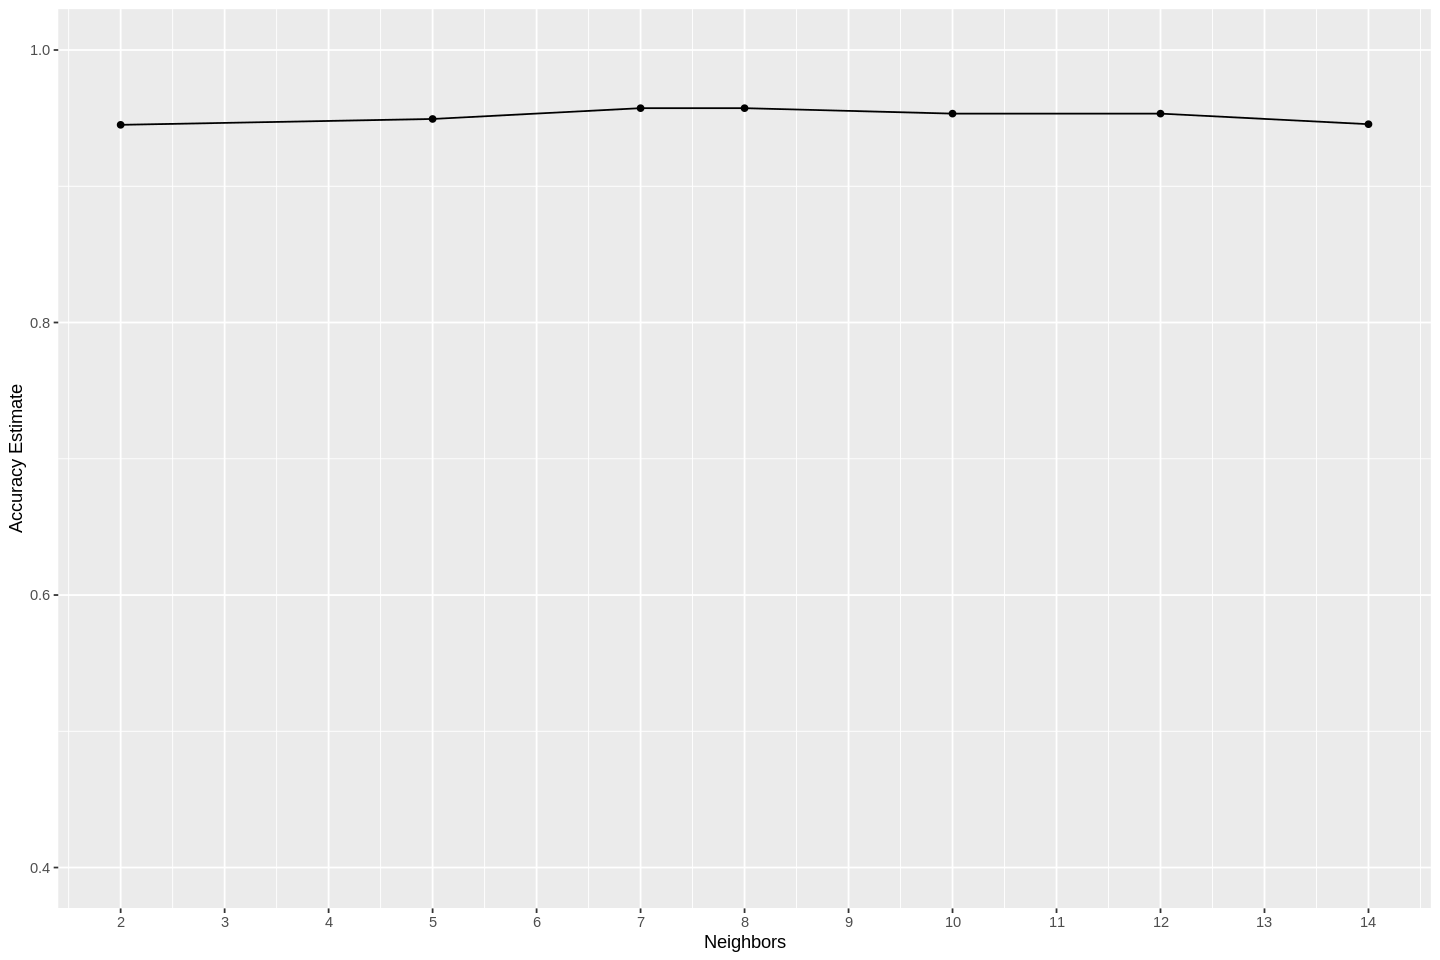

In [55]:

# Training (Historical discrepancy score (numbers) and the in unplanned expenditures (PARA_B))
audit_split2 <- initial_split(audit_trial2, prop = 3/4, strata = Risk)  
audit_train2 <- training(audit_split2)   
audit_test2 <- testing(audit_split2)

audit_recipe_2 <- recipe(Risk ~ numbers + TOTAL + Money_Value, data = audit_train2) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())


knn_results_2 <- workflow() %>%
    add_recipe(audit_recipe_2) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = 10) %>%
    collect_metrics()

accuracies_2 <- knn_results_2 %>% 
    filter(.metric == 'accuracy')

accuracy_versus_k2 <- ggplot(accuracies_2, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k2

In [56]:
## K = 3 seems to be the most accurate
audit_knn_spec2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 3) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_fit2 <- workflow() %>%
    add_recipe(audit_recipe_2) %>%
    add_model(audit_knn_spec2) %>%
    fit(data = audit_train2)

audit_test_predictions2 <- predict(audit_fit2, audit_test2) %>%
    bind_cols(audit_test2)

predictions_accuracy2 <- audit_test_predictions2 %>%
    metrics(truth = Risk, estimate = .pred_class)             

predictions_accuracy2

audit_mat2 <- audit_test_predictions2 %>% 
    conf_mat(truth = Risk, estimate = .pred_class)   

audit_mat2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8627451
kap,binary,0.5812317


          Truth
Prediction  0  1
         0 14  9
         1  5 74

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`summarise()` ungrouping output (override with `.groups` argument)



Risk,n
<fct>,<int>
0,217
1,204


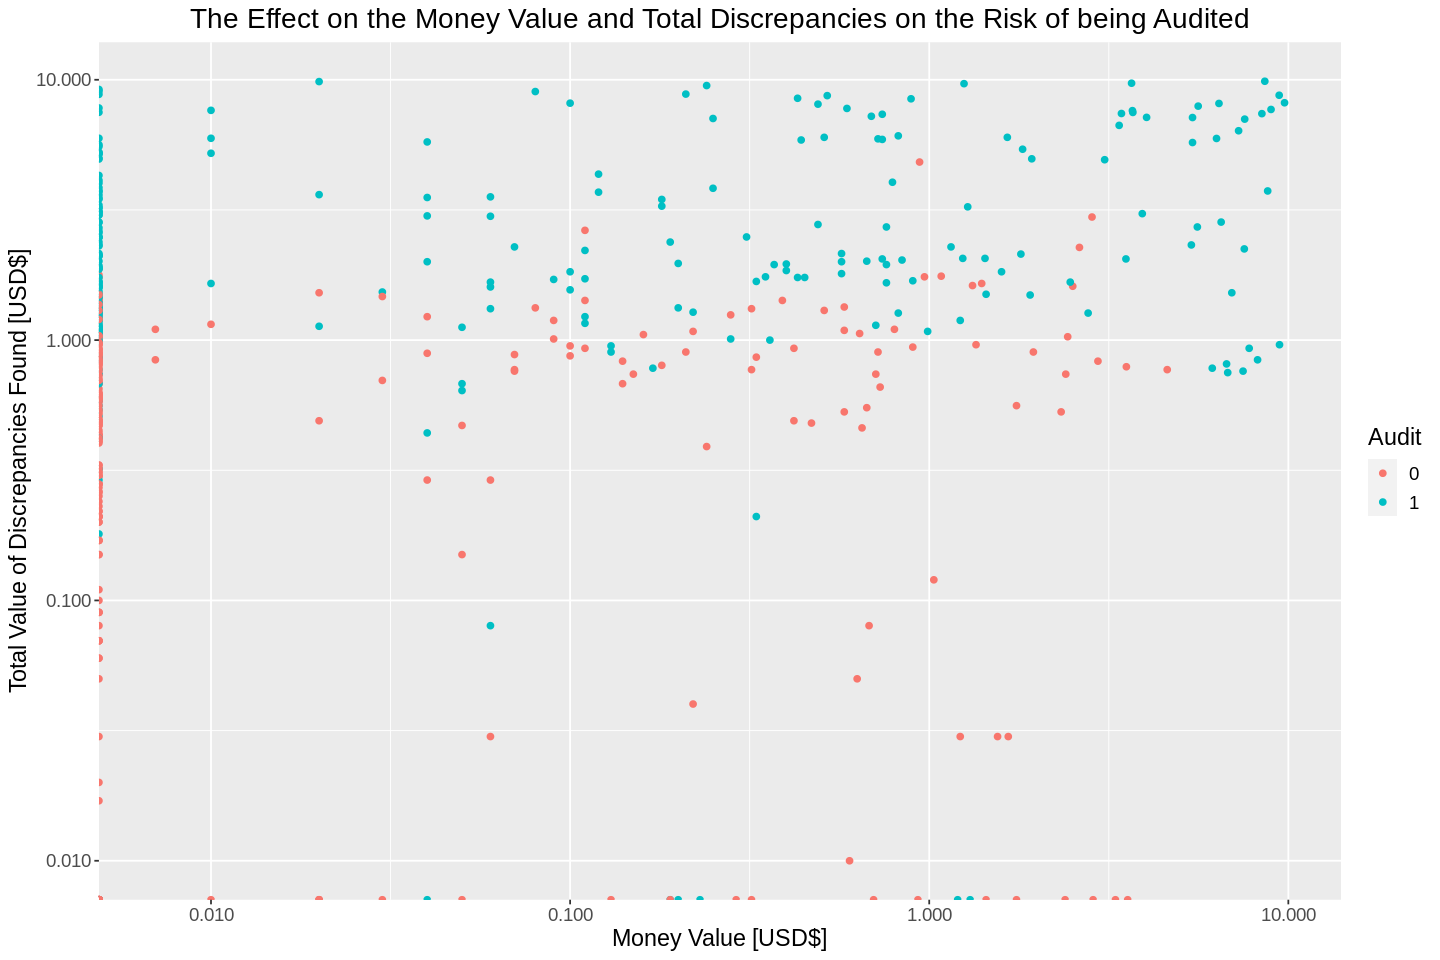

In [68]:
## Going to assume the second aproach is better
# Cleaning a wrangling our initial data, we want to use the original data


# We are interested in predicting the Risk Class, which are classified as 'Fraud' (1) or 'No-Fraud' (0)
# is the data evenly split in our training data? let's see


## Seems like most of our data is Fradulent firms, but looking at our visualization, we can see that all
## the firms that made a substantial amount of money were indeed auditted, so let's filter from our original
## data any high money making firms

audit_trial3 <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk)) %>%
    filter(TOTAL < 10, Money_Value < 10)

audit_plot_3 <- audit_trial3 %>%
    ggplot(aes(x = Money_Value, y = TOTAL, colour = Risk)) +
    geom_point() +
    labs(x = "Money Value [USD$]", y = "Total Value of Discrepancies Found [USD$]", colour = "Audit") +
    ggtitle("The Effect on the Money Value and Total Discrepancies on the Risk of being Audited") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) 
audit_plot_3
## That looks more even, let's make another training set and count to make sure it is even

audit_split3 <- initial_split(audit_trial3, prop = 3/4, strata = Risk)  
audit_train3 <- training(audit_split3)   
audit_test3 <- testing(audit_split3)

## That looks much more even, we can assume that with this data if the values of either Money_value
## and TOTAL are over 10, the firm was Fraudulent
counts <- audit_train3 %>%
    group_by(Risk) %>%
    summarize(n = n())
counts


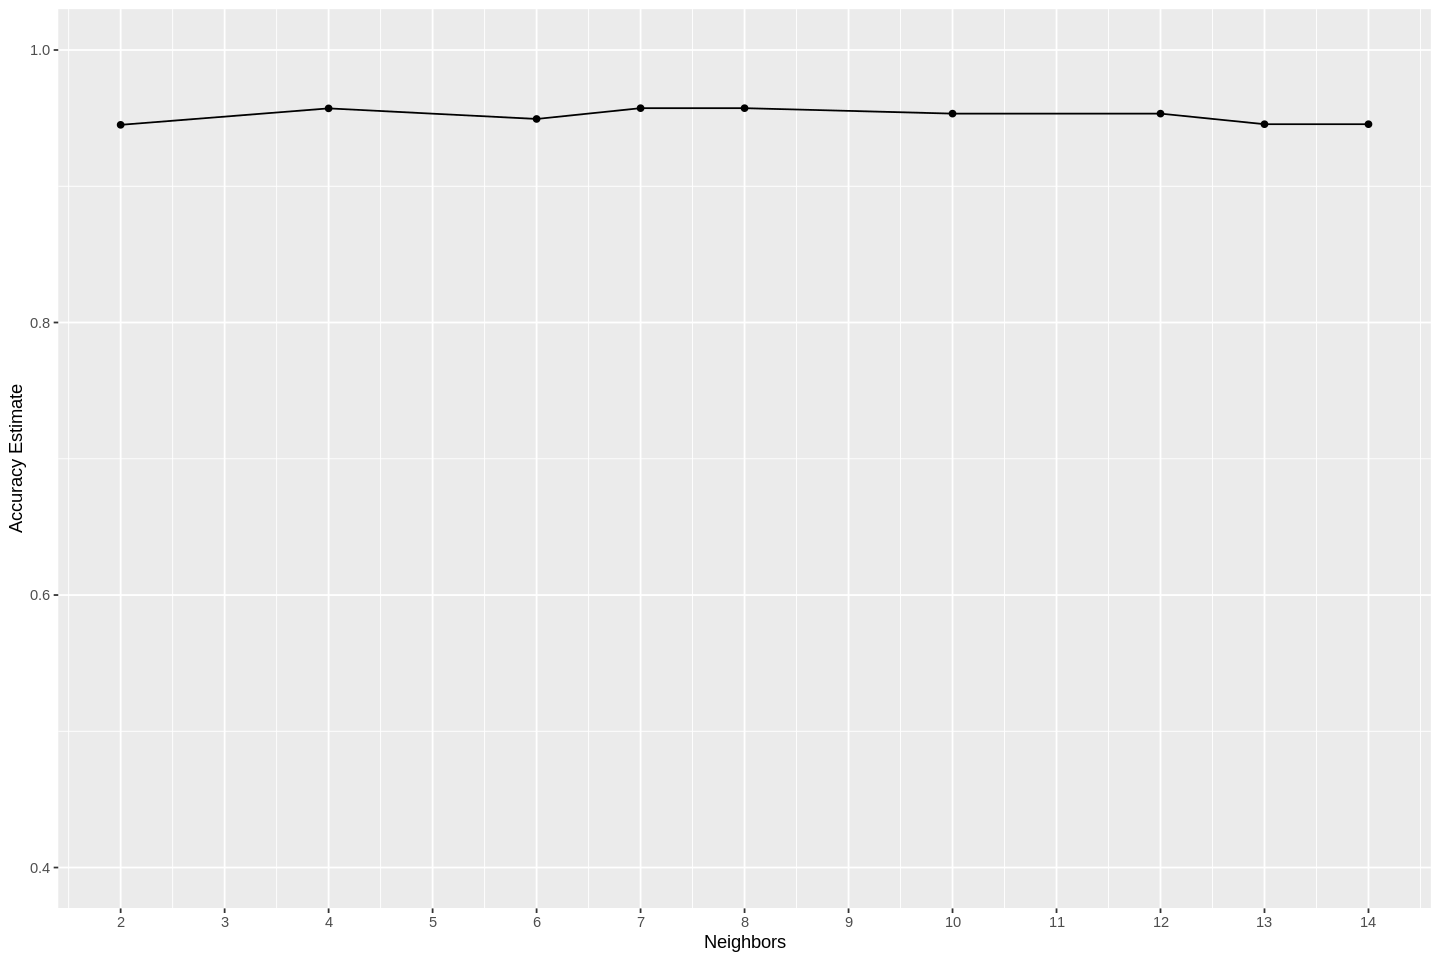

In [69]:
audit_recipe_3 <- recipe(Risk ~ numbers + TOTAL + Money_Value, data = audit_train3) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())


knn_results_3 <- workflow() %>%
    add_recipe(audit_recipe_3) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = 10) %>%
    collect_metrics()

accuracies_3 <- knn_results_3 %>% 
    filter(.metric == 'accuracy')

accuracy_versus_k3 <- ggplot(accuracies_3, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k3

In [71]:
## K = 4 seems to be the most accurate
audit_knn_spec3 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 4) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_fit3 <- workflow() %>%
    add_recipe(audit_recipe_3) %>%
    add_model(audit_knn_spec3) %>%
    fit(data = audit_train3)

audit_test_predictions3 <- predict(audit_fit3, audit_test3) %>%
    bind_cols(audit_test3)

predictions_accuracy3 <- audit_test_predictions3 %>%
    metrics(truth = Risk, estimate = .pred_class)             

predictions_accuracy3

audit_mat3 <- audit_test_predictions3 %>% 
    conf_mat(truth = Risk, estimate = .pred_class)   

audit_mat3

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8000000
kap,binary,0.5986896


          Truth
Prediction  0  1
         0 61 17
         1 11 51